In [1]:
import pandas as pd, numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, hamming_loss

%matplotlib inline
pd.set_option('display.max_colwidth', 600)

In [2]:
# Load book data for train and test sets
# books_train = pd.read_csv('data/book_sampled50k.csv').drop(columns=['Unnamed: 0'])
# books_test = pd.read_csv('data/book_test_10k.csv').drop(columns=['Unnamed: 0'])

books_train = pd.read_csv('doc2vec_v1/books_train.csv')
books_test = pd.read_csv('doc2vec_v1/books_test.csv')

print(books_train.shape)
print(books_test.shape)

(50000, 10)
(10000, 10)


In [3]:
# Load lda trained topics for train and test sets
# topics_train = pd.read_csv('data/df_document_topic_v4.csv').drop(['Unnamed: 0'], axis=1)
# topics_test = pd.read_csv('data/df_document_topic_test.csv').drop(['Unnamed: 0'], axis=1)

topics_train = pd.read_csv('doc2vec_v1/vector_train.csv')
topics_test = pd.read_csv('doc2vec_v1/vector_test.csv')

print(topics_train.shape)
print(topics_test.shape)

x_train = topics_train.copy()
x_test = topics_test.copy()

(50000, 2000)
(10000, 2000)


In [4]:
# split genres into genre lists for train and test data
books_train['genrelist'] = books_train['genres'].apply(lambda x: x[1:-1].split("', '"))
books_test['genrelist'] = books_test['genres'].apply(lambda x: x[1:-1].split("', '"))

In [5]:
# # Get entire list of genres from training set.
genres_list = [] 

# extract genres
for i in books_train['genrelist']: 
    for j in i:
        genres_list.append(j)

# remove 'fiction' as a genre since its a global genre for all books in this dataset.
# remove 'unfinshed' as a genre
genres_list = list(filter(lambda x: x != 'fiction', genres_list))
genres_list = list(filter(lambda x: x != 'unfinished', genres_list))
        
# Number of unique
print("Unique Genres: ",len(set(genres_list)))
unique_genre_list = list(set(genres_list))

Unique Genres:  977


### Select top 50 Genres

In [6]:
all_genres = nltk.FreqDist(genres_list) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

top50_genres = all_genres_df.nlargest(columns="Count", n = 50) 
unique_genre_list_top50 = list(top50_genres.Genre)

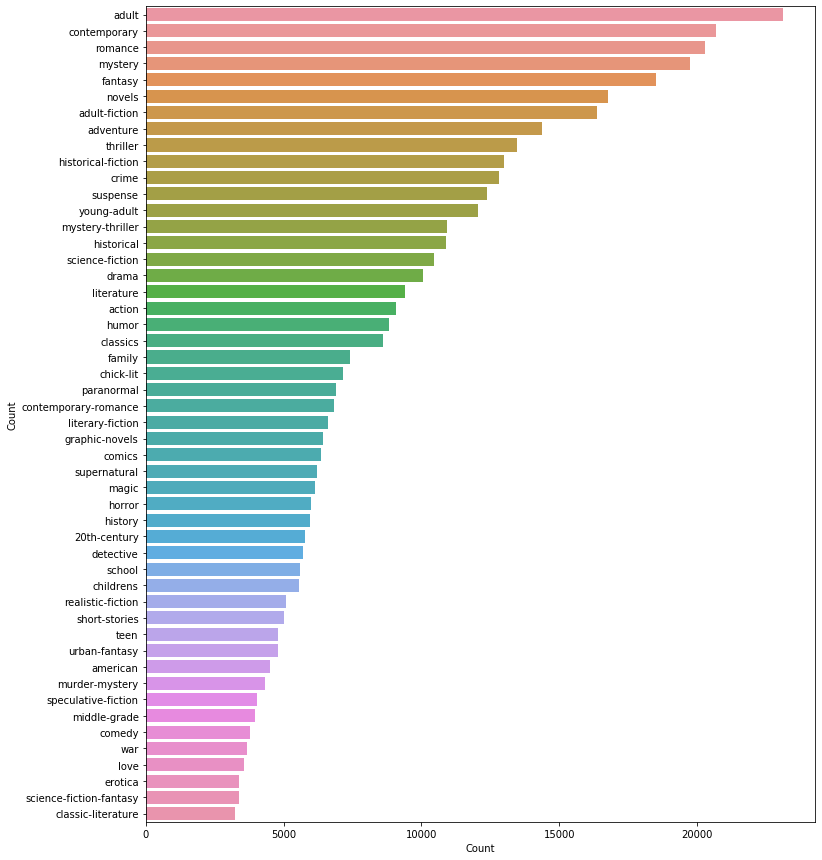

In [7]:
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=top50_genres, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

### Create train / test genre list based on top 50 genres

In [8]:
# set training data
y_traindf = pd.DataFrame()
y_traindf['genrelist'] = books_train['genrelist']
y_traindf['genrelist_intop50'] = y_traindf['genrelist'].apply(lambda y: [x for x in y if x in unique_genre_list_top50])

y_traindf['genrelist_intop50_top5']=y_traindf['genrelist_intop50'].apply(lambda x: ['' if len(x) < 1 else x[0],
                                                                          '' if len(x) < 2 else x[1],
                                                                          '' if len(x) < 3 else x[2],
                                                                          '' if len(x) < 4 else x[3],
                                                                          '' if len(x) < 5 else x[4]])

y_traindf.head(3)

,genrelist,genrelist_intop50,genrelist_intop50_top5
0,"[young-adult, romance, contemporary, fiction, realistic-fiction, teen, coming-of-age, family, mental-health, illness, love, contemporary-romance, mental-illness, chick-lit, novels, high-school, drama]","[young-adult, romance, contemporary, realistic-fiction, teen, family, love, contemporary-romance, chick-lit, novels, drama]","[young-adult, romance, contemporary, realistic-fiction, teen]"
1,"[classics, fiction, historical-fiction, literature, british-literature, historical, romance, novels, victorian, european-literature, 20th-century, literary-fiction, religion, modern-classics, adult-fiction, 19th-century, english-literature, drama]","[classics, historical-fiction, literature, historical, romance, novels, 20th-century, literary-fiction, adult-fiction, drama]","[classics, historical-fiction, literature, historical, romance]"
2,"[zombies, horror, post-apocalyptic, fiction, science-fiction, apocalyptic, thriller, survival, dystopia, adult, action, fantasy]","[horror, science-fiction, thriller, adult, action, fantasy]","[horror, science-fiction, thriller, adult, action]"


In [9]:
# set testing data
y_testdf = pd.DataFrame() 
y_testdf['genrelist'] = books_test['genrelist']
y_testdf['genrelist_intop50'] = y_testdf['genrelist'].apply(lambda y: [x for x in y if x in unique_genre_list_top50])

y_testdf['genrelist_intop50_top5']=y_testdf['genrelist_intop50'].apply(lambda x: ['' if len(x) < 1 else x[0],
                                                                          '' if len(x) < 2 else x[1],
                                                                          '' if len(x) < 3 else x[2],
                                                                          '' if len(x) < 4 else x[3],
                                                                          '' if len(x) < 5 else x[4]])

y_testdf.head(3)

,genrelist,genrelist_intop50,genrelist_intop50_top5
0,"[science-fiction, fiction, speculative-fiction, science, environment, ecology, science-fiction-fantasy, climate-change, 21st-century, technology, literature]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]"
1,"[fiction, humor, race, contemporary, novels, literary-fiction, african-american, literature, american, comedy, 21st-century, unfinished, politics, adult-fiction, adult, social-justice]","[humor, contemporary, novels, literary-fiction, literature, american, comedy, adult-fiction, adult]","[humor, contemporary, novels, literary-fiction, literature]"
2,"[science-fiction, fiction, science-fiction-fantasy, unfinished, science, space-opera, collections, short-stories]","[science-fiction, science-fiction-fantasy, short-stories]","[science-fiction, science-fiction-fantasy, short-stories, , ]"


### Binarize genre labels

In [10]:
# Append the 2 dataframe together before doing the MultiLabelBinarizer
listtogetbinary = pd.DataFrame()
listtogetbinary['genrelist_intop50_top5'] = y_traindf['genrelist_intop50_top5']
listtogetbinary = listtogetbinary.append(y_testdf[['genrelist_intop50_top5']]).reset_index(drop=True)
print(listtogetbinary.shape)

(60000, 1)


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()

y = multilabel_binarizer.fit_transform(listtogetbinary['genrelist_intop50_top5'])
genre_class = multilabel_binarizer.classes_

# delete empty string genre ''
y = np.delete(y, 0, 1)    
genre_class = np.delete(genre_class, 0)

print(y.shape)
print(genre_class.shape)

(60000, 50)
(50,)


In [12]:
train_length = int(topics_train.shape[0])
test_length_start = int(train_length)

# reorder the genre targets according to its frequency
y_df = pd.DataFrame(y, columns = genre_class)
y_df_reordered = y_df[unique_genre_list_top50].copy()

train_y_processed= y_df_reordered.iloc[:train_length,:]
test_y_processed = y_df_reordered.iloc[train_length:,:]

print("Training data shape:", x_train.shape)
print("Training labels shape:", train_y_processed.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", test_y_processed.shape)

Training data shape: (50000, 2000)
Training labels shape: (50000, 50)
Testing data shape: (10000, 2000)
Testing labels shape: (10000, 50)


# Models

In [13]:
# function to get results from predict_proba matrix
def get_results(prediction_proba):
    df = pd.DataFrame(prediction_proba.todense(), columns = unique_genre_list_top50)

    df['top5_pred']=df.apply(lambda x: list(x.nlargest(5).index), axis=1)
    df['top5_actual'] = listtogetbinary['genrelist_intop50_top5'][train_length:].reset_index().drop(columns=['index'])

    df[['top5_pred','top5_actual']]

    df = df[['top5_pred','top5_actual']].copy()
    df['genre_match_count'] = df.apply(lambda x: len(set(x['top5_pred']) & set(x['top5_actual'])), axis=1)

    df['percent_match'] = df.apply(
        lambda x: x['genre_match_count'] / (1 if len(list(filter(lambda y: y != '', x['top5_actual'])))==0 else len(list(filter(lambda y: y != '', x['top5_actual'])))), 
        axis=1)
    
    match_20_per = df[df.percent_match >= 0.2].count()[0] / len(df)
    match_40_per = df[df.percent_match >= 0.4].count()[0] / len(df)
    match_60_per = df[df.percent_match >= 0.6].count()[0] / len(df)
    match_80_per = df[df.percent_match >= 0.8].count()[0] / len(df)
    match_100_per = df[df.percent_match >= 1.0].count()[0] / len(df)

    print("% of books with at least 20% of genre matched:", round(match_20_per*100,2),'%')
    print("% of books with at least 40% of genre matched:",round(match_40_per*100,2),'%')
    print("% of books with at least 60% of genre matched:",round(match_60_per*100,2),'%')
    print("% of books with at least 80% of genre matched:",round(match_80_per*100,2),'%')
    print("% of books with at least 100% of genre matched:",round(match_100_per*100,2),'%')
    
    return df

### Label Powerset

In [14]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB

# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
classifier_ps = LabelPowerset(GaussianNB())

# train
%time classifier_ps.fit(x_train, train_y_processed.values)

# predict
%time predictions_ps = classifier_ps.predict(x_test)
%time probability_ps = classifier_ps.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, predictions_ps.todense()))
# print("f1 score: ",f1_score(test_y_processed, predictions_ps.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, predictions_ps.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, predictions_ps.todense()))

Wall time: 8.66 s
Wall time: 45min 42s
Wall time: 1h 32min 35s


In [15]:
ps_results_df = get_results(probability_ps)
# ps_results_df.to_csv('d2v_ps_results_df.csv')
# pickle.dump(classifier_ps, open('d2v_classifier_ps.model', 'wb'))
ps_results_df

% of books with at least 20% of genre matched: 83.3 %
% of books with at least 40% of genre matched: 59.14 %
% of books with at least 60% of genre matched: 35.58 %
% of books with at least 80% of genre matched: 14.95 %
% of books with at least 100% of genre matched: 4.5 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, speculative-fiction, mystery, adventure, thriller]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",2,0.500000
1,"[mystery, thriller, historical-fiction, mystery-thriller, historical]","[humor, contemporary, novels, literary-fiction, literature]",0,0.000000
2,"[fantasy, adventure, science-fiction, science-fiction-fantasy, war]","[science-fiction, science-fiction-fantasy, short-stories, , ]",2,0.666667
3,"[adult, mystery, thriller, suspense, mystery-thriller]","[historical-fiction, mystery, romance, historical, suspense]",2,0.400000
4,"[romance, young-adult, graphic-novels, humor, comics]","[mystery, suspense, romance, thriller, contemporary-romance]",1,0.200000
5,"[adventure, mystery, thriller, suspense, mystery-thriller]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[adventure, science-fiction, action, graphic-novels, comics]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",3,0.750000
7,"[fantasy, adventure, science-fiction, speculative-fiction, science-fiction-fantasy]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",4,0.800000
8,"[fantasy, horror, short-stories, drama, literature]","[science-fiction, mystery, fantasy, horror, adult]",2,0.400000
9,"[fantasy, science-fiction, horror, short-stories, speculative-fiction]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",3,0.600000


### Adapted Algorithm

In [16]:
from skmultilearn.adapt import MLkNN

classifier_aa = MLkNN(k=20)

# train
%time classifier_aa.fit(x_train, train_y_processed.values)

# predict
%time predictions_aa = classifier_aa.predict(x_test)
%time probability_aa = classifier_aa.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed.values, predictions_aa.todense()))
# print("f1 score: ",f1_score(test_y_processed.values, predictions_aa.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed.values, predictions_aa.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed.values, predictions_aa.todense()))

Wall time: 2h 6min 38s
Wall time: 28min 32s
Wall time: 28min 29s


In [17]:
aa_results_df = get_results(probability_aa)
# aa_results_df.to_csv('d2v_aa_results_df.csv')
# pickle.dump(classifier_aa, open('d2v_classifier_aa.model', 'wb'))
aa_results_df

% of books with at least 20% of genre matched: 82.91 %
% of books with at least 40% of genre matched: 43.62 %
% of books with at least 60% of genre matched: 13.15 %
% of books with at least 80% of genre matched: 2.11 %
% of books with at least 100% of genre matched: 0.83 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[adult, horror, novels, contemporary, thriller]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",0,0.000000
1,"[contemporary, adult-fiction, science-fiction, drama, historical-fiction]","[humor, contemporary, novels, literary-fiction, literature]",1,0.200000
2,"[adult, historical-fiction, fantasy, romance, young-adult]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[contemporary, adult-fiction, historical-fiction, paranormal, young-adult]","[historical-fiction, mystery, romance, historical, suspense]",1,0.200000
4,"[romance, adult, young-adult, fantasy, contemporary]","[mystery, suspense, romance, thriller, contemporary-romance]",1,0.200000
5,"[historical-fiction, contemporary, historical, adventure, mystery]","[thriller, suspense, contemporary, , ]",1,0.333333
6,"[fantasy, young-adult, romance, historical-fiction, paranormal]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",0,0.000000
7,"[adult, fantasy, mystery, adult-fiction, thriller]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",1,0.200000
8,"[adult, historical-fiction, young-adult, contemporary, mystery]","[science-fiction, mystery, fantasy, horror, adult]",2,0.400000
9,"[fantasy, mystery, thriller, adventure, novels]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",2,0.400000


### Ensemble

In [18]:
# from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD

classifier_R1D = RakelD(
    base_classifier=GaussianNB(),
    base_classifier_require_dense=[True, True],
    labelset_size=10
)

%time classifier_R1D.fit(x_train, train_y_processed)
%time prediction_R1D = classifier_R1D.predict(x_test)
%time probability_R1D = classifier_R1D.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, prediction_R1D.todense()))
# print("f1 score: ",f1_score(test_y_processed, prediction_R1D.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, prediction_R1D.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, prediction_R1D.todense()))

Wall time: 16.1 s
Wall time: 2min 32s
Wall time: 3min 44s


In [19]:
R1D_results_df = get_results(probability_R1D)
# R1D_results_df.to_csv('d2v_R1D_results_df.csv')
# pickle.dump(classifier_R1D, open('d2v_classifier_R1D.model', 'wb'))
R1D_results_df

% of books with at least 20% of genre matched: 84.99 %
% of books with at least 40% of genre matched: 55.47 %
% of books with at least 60% of genre matched: 24.11 %
% of books with at least 80% of genre matched: 5.74 %
% of books with at least 100% of genre matched: 1.67 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[mystery, historical-fiction, suspense, science-fiction, literary-fiction]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[adult, adult-fiction, historical-fiction, crime, drama]","[humor, contemporary, novels, literary-fiction, literature]",0,0.000000
2,"[speculative-fiction, fantasy, novels, adventure, historical-fiction]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[adult, romance, mystery, adult-fiction, crime]","[historical-fiction, mystery, romance, historical, suspense]",2,0.400000
4,"[contemporary, romance, mystery, graphic-novels, comics]","[mystery, suspense, romance, thriller, contemporary-romance]",2,0.400000
5,"[novels, adventure, historical-fiction, suspense, science-fiction]","[thriller, suspense, contemporary, , ]",1,0.333333
6,"[science-fiction, comics, romance, action, science-fiction-fantasy]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",3,0.750000
7,"[thriller, action, graphic-novels, speculative-fiction, science-fiction-fantasy]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[romance, crime, drama, action, humor]","[science-fiction, mystery, fantasy, horror, adult]",0,0.000000
9,"[novels, adventure, historical-fiction, science-fiction, action]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",2,0.400000


### Classifier Chains

In [20]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier_cc = ClassifierChain(GaussianNB())

# train
%time classifier_cc.fit(x_train, train_y_processed)

# predict
%time predictions_cc = classifier_cc.predict(x_test)
%time probability_cc = classifier_cc.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, predictions_cc.todense()))
# print("f1 score: ",f1_score(test_y_processed, predictions_cc.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, predictions_cc.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, predictions_cc.todense()))

Wall time: 3min 1s
Wall time: 35.3 s
Wall time: 1min 4s


In [21]:
cc_results_df = get_results(probability_cc)
# cc_results_df.to_csv('d2v_cc_results_df.csv')
# pickle.dump(classifier_cc, open('d2v_classifier_cc.model', 'wb'))
cc_results_df

% of books with at least 20% of genre matched: 87.08 %
% of books with at least 40% of genre matched: 64.37 %
% of books with at least 60% of genre matched: 34.78 %
% of books with at least 80% of genre matched: 9.01 %
% of books with at least 100% of genre matched: 2.64 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[novels, thriller, science-fiction, drama, literature]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",2,0.500000
1,"[novels, adult-fiction, historical-fiction, historical, drama]","[humor, contemporary, novels, literary-fiction, literature]",1,0.200000
2,"[adult, fantasy, novels, adventure, historical-fiction]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[adult, contemporary, romance, adult-fiction, historical-fiction]","[historical-fiction, mystery, romance, historical, suspense]",2,0.400000
4,"[contemporary, romance, young-adult, humor, family]","[mystery, suspense, romance, thriller, contemporary-romance]",1,0.200000
5,"[adult, novels, thriller, historical-fiction, suspense]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[fantasy, adventure, young-adult, science-fiction, action]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",1,0.250000
7,"[fantasy, adventure, thriller, young-adult, science-fiction]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[adult, novels, historical-fiction, historical, drama]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[adult, novels, historical-fiction, science-fiction, drama]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",2,0.400000


### Dummy Classifier

In [22]:
# Copy a results df
dummy_results_df = R1D_results_df[['top5_pred','top5_actual']].copy()

# Get genre set for each book (not ordered)
dummy_results_df['Sets'] = dummy_results_df['top5_actual'].apply(set).astype(str)

# get most common genre set
dummy_results_df[dummy_results_df['Sets'] == dummy_results_df['Sets'].value_counts().idxmax()]
most_common_genre_set = dummy_results_df[dummy_results_df['Sets'] == dummy_results_df['Sets'].value_counts().idxmax()].iloc[0].top5_actual

# set the most common genre set as the pred for all books
dummy_results_df['top5_pred'] = dummy_results_df['top5_pred'].apply(lambda x: most_common_genre_set)

# Match data
dummy_results_df['genre_match_count'] = dummy_results_df.apply(lambda x: len(set(x['top5_pred']) & set(x['top5_actual'])), axis=1)

dummy_results_df['percent_match'] = dummy_results_df.apply(
    lambda x: x['genre_match_count'] / (1 if len(list(filter(lambda y: y != '', x['top5_actual'])))==0 else len(list(filter(lambda y: y != '', x['top5_actual'])))), 
    axis=1)

# Compute results
match_20_per = dummy_results_df[dummy_results_df.percent_match >= 0.2].count()[0] / len(dummy_results_df)
match_40_per = dummy_results_df[dummy_results_df.percent_match >= 0.4].count()[0] / len(dummy_results_df)
match_60_per = dummy_results_df[dummy_results_df.percent_match >= 0.6].count()[0] / len(dummy_results_df)
match_80_per = dummy_results_df[dummy_results_df.percent_match >= 0.8].count()[0] / len(dummy_results_df)
match_100_per = dummy_results_df[dummy_results_df.percent_match >= 1.0].count()[0] / len(dummy_results_df)

print("% of books with at least 20% of genre matched:", round(match_20_per*100,2),'%')
print("% of books with at least 40% of genre matched:",round(match_40_per*100,2),'%')
print("% of books with at least 60% of genre matched:",round(match_60_per*100,2),'%')
print("% of books with at least 80% of genre matched:",round(match_80_per*100,2),'%')
print("% of books with at least 100% of genre matched:",round(match_100_per*100,2),'%')

dummy_results_df = dummy_results_df.drop(columns=['Sets'])
dummy_results_df

% of books with at least 20% of genre matched: 55.15 %
% of books with at least 40% of genre matched: 30.18 %
% of books with at least 60% of genre matched: 15.14 %
% of books with at least 80% of genre matched: 8.35 %
% of books with at least 100% of genre matched: 3.72 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",0,0.000000
1,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[humor, contemporary, novels, literary-fiction, literature]",1,0.200000
2,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[historical-fiction, mystery, romance, historical, suspense]",1,0.200000
4,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[mystery, suspense, romance, thriller, contemporary-romance]",2,0.400000
5,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[thriller, suspense, contemporary, , ]",1,0.333333
6,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",0,0.000000
7,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",0,0.000000
8,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[romance, contemporary-romance, contemporary, chick-lit, adult]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",1,0.200000


# Tuning

### Ensemble (SGD Loss = modified_huber)

In [23]:
# from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.linear_model import SGDClassifier

classifier_R1D_SGD_MH = RakelD(
    base_classifier=SGDClassifier(max_iter=10000, n_jobs = 8,loss = 'modified_huber'),
    base_classifier_require_dense=[True, True],
    labelset_size=10
)

%time classifier_R1D_SGD_MH.fit(x_train, train_y_processed)
%time prediction_R1D_SGD_MH = classifier_R1D_SGD_MH.predict(x_test)
%time probability_R1D_SGD_MH = classifier_R1D_SGD_MH.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, prediction_R1D_SGD_MH.todense()))
# print("f1 score: ",f1_score(test_y_processed, prediction_R1D_SGD_MH.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, prediction_R1D_SGD_MH.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, prediction_R1D_SGD_MH.todense()))

Wall time: 2min 35s
Wall time: 4.5 s
Wall time: 1min 28s


In [24]:
R1D_SGD_MH_results_df = get_results(probability_R1D_SGD_MH)
# R1D_SGD_MH_results_df.to_csv('d2v_R1D_SGD_MH_results_df.csv')
# pickle.dump(classifier_R1D_SGD_MH, open('d2v_classifier_R1D_SGD_MH.model', 'wb'))
R1D_SGD_MH_results_df

% of books with at least 20% of genre matched: 94.34 %
% of books with at least 40% of genre matched: 76.77 %
% of books with at least 60% of genre matched: 48.2 %
% of books with at least 80% of genre matched: 18.74 %
% of books with at least 100% of genre matched: 5.26 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, mystery, thriller, novels, literature]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",2,0.500000
1,"[historical-fiction, mystery, classics, literature, crime]","[humor, contemporary, novels, literary-fiction, literature]",1,0.200000
2,"[historical-fiction, historical, adventure, fantasy, romance]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[romance, mystery, adult, suspense, contemporary]","[historical-fiction, mystery, romance, historical, suspense]",3,0.600000
4,"[romance, contemporary, contemporary-romance, adult, fantasy]","[mystery, suspense, romance, thriller, contemporary-romance]",2,0.400000
5,"[thriller, mystery, suspense, war, historical-fiction]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[romance, fantasy, historical-fiction, graphic-novels, historical]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",1,0.250000
7,"[science-fiction, fantasy, mystery, graphic-novels, adventure]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[historical-fiction, mystery, graphic-novels, adventure, suspense]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[science-fiction, fantasy, speculative-fiction, novels, science-fiction-fantasy]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",3,0.600000


### Ensemble (SGD Loss = log)

In [25]:
# from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.linear_model import SGDClassifier

classifier_R1D_SGD_LOG = RakelD(
    base_classifier=SGDClassifier(max_iter=10000, n_jobs = 8,loss = 'log'),
    base_classifier_require_dense=[True, True],
    labelset_size=10
)

%time classifier_R1D_SGD_LOG.fit(x_train, train_y_processed)
%time prediction_R1D_SGD_LOG = classifier_R1D_SGD_LOG.predict(x_test)
%time probability_R1D_SGD_LOG = classifier_R1D_SGD_LOG.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, prediction_R1D_SGD_LOG.todense()))
# print("f1 score: ",f1_score(test_y_processed, prediction_R1D_SGD_LOG.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, prediction_R1D_SGD_LOG.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, prediction_R1D_SGD_LOG.todense()))

Wall time: 2min 44s
Wall time: 4.58 s
Wall time: 1min 21s


In [26]:
R1D_SGD_LOG_results_df = get_results(probability_R1D_SGD_LOG)
# R1D_SGD_LOG_results_df.to_csv('d2v_R1D_SGD_LOG_results_df.csv')
# pickle.dump(classifier_R1D_SGD_LOG, open('d2v_classifier_R1D_SGD_LOG.model', 'wb'))
R1D_SGD_LOG_results_df

% of books with at least 20% of genre matched: 95.66 %
% of books with at least 40% of genre matched: 80.72 %
% of books with at least 60% of genre matched: 51.78 %
% of books with at least 80% of genre matched: 19.96 %
% of books with at least 100% of genre matched: 5.97 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, mystery, thriller, fantasy, comics]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[historical-fiction, classics, mystery, literature, crime]","[humor, contemporary, novels, literary-fiction, literature]",1,0.200000
2,"[fantasy, adventure, science-fiction, historical-fiction, historical]","[science-fiction, science-fiction-fantasy, short-stories, , ]",1,0.333333
3,"[romance, contemporary, adult, contemporary-romance, mystery]","[historical-fiction, mystery, romance, historical, suspense]",2,0.400000
4,"[romance, contemporary, fantasy, mystery, adult]","[mystery, suspense, romance, thriller, contemporary-romance]",2,0.400000
5,"[thriller, mystery, suspense, action, mystery-thriller]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[fantasy, romance, adventure, graphic-novels, comics]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",2,0.500000
7,"[fantasy, science-fiction, mystery, adventure, thriller]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[thriller, adventure, mystery, science-fiction, historical-fiction]","[science-fiction, mystery, fantasy, horror, adult]",2,0.400000
9,"[science-fiction, fantasy, novels, speculative-fiction, adventure]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",4,0.800000


### Ensemble (RF)

In [27]:
from skmultilearn.ensemble import RakelD
from sklearn.ensemble import RandomForestClassifier

classifier_R1D_RF1 = RakelD(
    base_classifier=RandomForestClassifier(random_state=0, n_jobs=8, n_estimators=200),
    base_classifier_require_dense=[True, True],
    labelset_size=10
)

%time classifier_R1D_RF1.fit(x_train, train_y_processed)
%time prediction_R1D_RF1 = classifier_R1D_RF1.predict(x_test)
%time probability_R1D_RF1 = classifier_R1D_RF1.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, prediction_R1D_RF1.todense()))
# print("f1 score: ",f1_score(test_y_processed, prediction_R1D_RF1.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, prediction_R1D_RF1.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, prediction_R1D_RF1.todense()))

Wall time: 19min
Wall time: 6min 54s
Wall time: 4min 18s


In [28]:
R1D_RF1_results_df = get_results(probability_R1D_RF1)
# R1D_RF1_results_df.to_csv('d2v_R1D_RF1_results_df.csv')
# pickle.dump(classifier_R1D_RF1, open('d2v_classifier_R1D_RF1.model', 'wb'))
R1D_RF1_results_df

% of books with at least 20% of genre matched: 95.99 %
% of books with at least 40% of genre matched: 80.67 %
% of books with at least 60% of genre matched: 49.4 %
% of books with at least 80% of genre matched: 17.79 %
% of books with at least 100% of genre matched: 4.85 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, fantasy, mystery, thriller, historical-fiction]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[mystery, historical-fiction, classics, thriller, historical]","[humor, contemporary, novels, literary-fiction, literature]",0,0.000000
2,"[fantasy, science-fiction, adventure, historical-fiction, young-adult]","[science-fiction, science-fiction-fantasy, short-stories, , ]",1,0.333333
3,"[contemporary, romance, adult, mystery, historical]","[historical-fiction, mystery, romance, historical, suspense]",3,0.600000
4,"[romance, contemporary, young-adult, fantasy, mystery]","[mystery, suspense, romance, thriller, contemporary-romance]",2,0.400000
5,"[thriller, mystery, historical-fiction, mystery-thriller, suspense]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[fantasy, adventure, science-fiction, graphic-novels, comics]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",3,0.750000
7,"[science-fiction, fantasy, adventure, mystery, thriller]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[mystery, fantasy, thriller, short-stories, historical-fiction]","[science-fiction, mystery, fantasy, horror, adult]",2,0.400000
9,"[science-fiction, fantasy, thriller, adventure, adult]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",4,0.800000


### Ensemble (RF estimator = 200 , criterion = entropy)

In [14]:
from skmultilearn.ensemble import RakelD
from sklearn.ensemble import RandomForestClassifier

classifier_R1D_RF2 = RakelD(
    base_classifier=RandomForestClassifier(random_state=0, n_jobs=8, n_estimators=200, criterion = 'entropy'),
    base_classifier_require_dense=[True, True],
    labelset_size=10
)

%time classifier_R1D_RF2.fit(x_train, train_y_processed)
%time prediction_R1D_RF2 = classifier_R1D_RF2.predict(x_test)
%time probability_R1D_RF2 = classifier_R1D_RF2.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, prediction_R1D_RF2.todense()))
# print("f1 score: ",f1_score(test_y_processed, prediction_R1D_RF2.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, prediction_R1D_RF2.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, prediction_R1D_RF2.todense()))

Wall time: 1h 7min 29s
Wall time: 39.8 s
Wall time: 1min 42s


In [15]:
R1D_RF2_results_df = get_results(probability_R1D_RF2)
# R1D_RF2_results_df.to_csv('d2v_R1D_RF2_results_df.csv')
# pickle.dump(classifier_R1D_RF2, open('d2v_classifier_R1D_RF2.model', 'wb'))
R1D_RF2_results_df

% of books with at least 20% of genre matched: 95.89 %
% of books with at least 40% of genre matched: 79.8 %
% of books with at least 60% of genre matched: 49.23 %
% of books with at least 80% of genre matched: 18.39 %
% of books with at least 100% of genre matched: 5.3 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, fantasy, mystery, literature, novels]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",2,0.500000
1,"[mystery, classics, historical-fiction, literature, crime]","[humor, contemporary, novels, literary-fiction, literature]",1,0.200000
2,"[fantasy, science-fiction, adventure, historical-fiction, war]","[science-fiction, science-fiction-fantasy, short-stories, , ]",1,0.333333
3,"[romance, contemporary, mystery, adult, contemporary-romance]","[historical-fiction, mystery, romance, historical, suspense]",2,0.400000
4,"[romance, contemporary, fantasy, young-adult, mystery]","[mystery, suspense, romance, thriller, contemporary-romance]",2,0.400000
5,"[mystery, thriller, suspense, adventure, historical-fiction]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[fantasy, adventure, science-fiction, young-adult, graphic-novels]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",2,0.500000
7,"[science-fiction, fantasy, mystery, adventure, thriller]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[mystery, fantasy, crime, science-fiction, short-stories]","[science-fiction, mystery, fantasy, horror, adult]",3,0.600000
9,"[science-fiction, fantasy, adventure, speculative-fiction, thriller]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",4,0.800000


### Ensemble (RF estimator = 300 , criterion = entropy)

In [14]:
from skmultilearn.ensemble import RakelD
from sklearn.ensemble import RandomForestClassifier

classifier_R1D_RF3 = RakelD(
    base_classifier=RandomForestClassifier(random_state=0, n_jobs=8, n_estimators=300, criterion = 'entropy'),
    base_classifier_require_dense=[True, True],
    labelset_size=10
)

%time classifier_R1D_RF3.fit(x_train, train_y_processed)
%time prediction_R1D_RF3 = classifier_R1D_RF3.predict(x_test)
%time probability_R1D_RF3 = classifier_R1D_RF3.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, prediction_R1D_RF3.todense()))
# print("f1 score: ",f1_score(test_y_processed, prediction_R1D_RF3.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, prediction_R1D_RF3.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, prediction_R1D_RF3.todense()))

Wall time: 1h 40min 45s
Wall time: 2min 25s
Wall time: 4min 1s


In [16]:
R1D_RF3_results_df = get_results(probability_R1D_RF3)
# R1D_RF3_results_df.to_csv('d2v_R1D_RF3_results_df.csv')
# pickle.dump(classifier_R1D_RF3, open('d2v_classifier_R1D_RF3.model', 'wb'))
R1D_RF3_results_df

% of books with at least 20% of genre matched: 96.03 %
% of books with at least 40% of genre matched: 80.69 %
% of books with at least 60% of genre matched: 50.64 %
% of books with at least 80% of genre matched: 19.08 %
% of books with at least 100% of genre matched: 5.4 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, fantasy, mystery, thriller, historical-fiction]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[historical-fiction, mystery, literature, classics, novels]","[humor, contemporary, novels, literary-fiction, literature]",2,0.400000
2,"[fantasy, science-fiction, adventure, historical-fiction, war]","[science-fiction, science-fiction-fantasy, short-stories, , ]",1,0.333333
3,"[romance, contemporary, adult, mystery, historical-fiction]","[historical-fiction, mystery, romance, historical, suspense]",3,0.600000
4,"[romance, contemporary, young-adult, fantasy, humor]","[mystery, suspense, romance, thriller, contemporary-romance]",1,0.200000
5,"[thriller, mystery, historical-fiction, suspense, science-fiction]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[fantasy, adventure, science-fiction, comics, historical-fiction]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",2,0.500000
7,"[science-fiction, fantasy, adventure, thriller, young-adult]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[fantasy, crime, short-stories, mystery, science-fiction]","[science-fiction, mystery, fantasy, horror, adult]",3,0.600000
9,"[science-fiction, fantasy, novels, speculative-fiction, adventure]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",4,0.800000


### Ensemble (LogisticRegression)

In [17]:
# from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.linear_model import LogisticRegression

classifier_R1D_LR = RakelD(
    base_classifier = LogisticRegression(random_state = 0, max_iter = 10000, n_jobs = 8),
    base_classifier_require_dense=[True, True],
    labelset_size=10
)

%time classifier_R1D_LR.fit(x_train, train_y_processed)
%time prediction_R1D_LR = classifier_R1D_LR.predict(x_test)
%time probability_R1D_LR = classifier_R1D_LR.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, prediction_R1D_LR.todense()))
# print("f1 score: ",f1_score(test_y_processed, prediction_R1D_LR.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, prediction_R1D_LR.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, prediction_R1D_LR.todense()))

Wall time: 58min 49s
Wall time: 7min 34s
Wall time: 1min 23s


In [18]:
R1D_LR_results_df = get_results(probability_R1D_LR)
# R1D_LR_results_df.to_csv('d2v_R1D_LR_results_df.csv')
# pickle.dump(classifier_R1D_LR, open('d2v_classifier_R1D_LR.model', 'wb'))
R1D_LR_results_df

% of books with at least 20% of genre matched: 95.19 %
% of books with at least 40% of genre matched: 79.97 %
% of books with at least 60% of genre matched: 53.05 %
% of books with at least 80% of genre matched: 23.02 %
% of books with at least 100% of genre matched: 7.1 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, thriller, novels, comics, graphic-novels]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[mystery, literature, historical-fiction, classics, novels]","[humor, contemporary, novels, literary-fiction, literature]",2,0.400000
2,"[historical-fiction, adventure, war, history, fantasy]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[romance, contemporary, mystery, adult, contemporary-romance]","[historical-fiction, mystery, romance, historical, suspense]",2,0.400000
4,"[romance, contemporary, adult, contemporary-romance, fantasy]","[mystery, suspense, romance, thriller, contemporary-romance]",2,0.400000
5,"[thriller, mystery, suspense, historical-fiction, war]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[fantasy, romance, adventure, historical-fiction, graphic-novels]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",1,0.250000
7,"[fantasy, science-fiction, adventure, novels, mystery]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",3,0.600000
8,"[thriller, adventure, graphic-novels, comics, science-fiction]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[science-fiction, fantasy, speculative-fiction, science-fiction-fantasy, novels]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",3,0.600000


### Ensemble (LogisticRegression: Newton-cg)

In [19]:
# from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.linear_model import LogisticRegression

classifier_R1D_LR_N = RakelD(
    base_classifier = LogisticRegression(random_state = 0, max_iter = 10000, n_jobs = 8, solver = 'newton-cg'),
    base_classifier_require_dense=[True, True],
    labelset_size=10
)

%time classifier_R1D_LR_N.fit(x_train, train_y_processed)
%time prediction_R1D_LR_N = classifier_R1D_LR_N.predict(x_test)
%time probability_R1D_LR_N = classifier_R1D_LR_N.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, prediction_R1D_LR_N.todense()))
# print("f1 score: ",f1_score(test_y_processed, prediction_R1D_LR_N.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, prediction_R1D_LR_N.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, prediction_R1D_LR_N.todense()))

Wall time: 58min 51s
Wall time: 4.14 s
Wall time: 1min 9s


In [20]:
R1D_LR_N_results_df = get_results(probability_R1D_LR_N)
# R1D_LR_N_results_df.to_csv('d2v_R1D_LR_N_results_df.csv')
# pickle.dump(classifier_R1D_LR_N, open('d2v_classifier_R1D_LR_N.model', 'wb'))
R1D_LR_N_results_df

% of books with at least 20% of genre matched: 95.37 %
% of books with at least 40% of genre matched: 80.19 %
% of books with at least 60% of genre matched: 53.09 %
% of books with at least 80% of genre matched: 22.38 %
% of books with at least 100% of genre matched: 6.42 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, thriller, fantasy, novels, comics]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[classics, historical-fiction, literature, mystery, crime]","[humor, contemporary, novels, literary-fiction, literature]",1,0.200000
2,"[adventure, historical-fiction, historical, fantasy, war]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[romance, suspense, contemporary, contemporary-romance, mystery]","[historical-fiction, mystery, romance, historical, suspense]",3,0.600000
4,"[romance, contemporary, young-adult, adult, fantasy]","[mystery, suspense, romance, thriller, contemporary-romance]",1,0.200000
5,"[thriller, mystery, suspense, adventure, mystery-thriller]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[fantasy, romance, adventure, graphic-novels, comics]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",2,0.500000
7,"[science-fiction, fantasy, adventure, mystery, comics]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[adventure, thriller, graphic-novels, science-fiction, historical-fiction]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[science-fiction, fantasy, speculative-fiction, adult, horror]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",4,0.800000


### Classifier Chains (SGD Loss = modified_huber)

In [37]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier_cc_SGD_MH = ClassifierChain(SGDClassifier(max_iter=10000, n_jobs = 8, loss = 'modified_huber'))

# train
%time classifier_cc_SGD_MH.fit(x_train, train_y_processed)

# predict
%time predictions_cc_SGD_MH = classifier_cc_SGD_MH.predict(x_test)
%time probability_cc_SGD_MH = classifier_cc_SGD_MH.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, predictions_cc_SGD_MH.todense()))
# print("f1 score: ",f1_score(test_y_processed, predictions_cc_SGD_MH.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, predictions_cc_SGD_MH.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, predictions_cc_SGD_MH.todense()))

Wall time: 4min 47s
Wall time: 12.7 s
Wall time: 18.4 s


In [38]:
cc_SGD_MH_results_df = get_results(probability_cc_SGD_MH)
# cc_SGD_MH_results_df.to_csv('d2v_cc_SGD_MH_results_df.csv')
# pickle.dump(classifier_cc_SGD_MH, open('d2v_classifier_cc_SGD_MH.model', 'wb'))
cc_SGD_MH_results_df

% of books with at least 20% of genre matched: 90.01 %
% of books with at least 40% of genre matched: 70.84 %
% of books with at least 60% of genre matched: 45.54 %
% of books with at least 80% of genre matched: 18.66 %
% of books with at least 100% of genre matched: 5.36 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, comics, graphic-novels, thriller, novels]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[historical-fiction, crime, mystery, historical, history]","[humor, contemporary, novels, literary-fiction, literature]",0,0.000000
2,"[historical-fiction, historical, history, adventure, war]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[romance, contemporary-romance, mystery, contemporary, adult]","[historical-fiction, mystery, romance, historical, suspense]",2,0.400000
4,"[comics, graphic-novels, humor, romance, comedy]","[mystery, suspense, romance, thriller, contemporary-romance]",1,0.200000
5,"[mystery, thriller, suspense, contemporary, science-fiction]","[thriller, suspense, contemporary, , ]",3,1.000000
6,"[erotica, contemporary-romance, romance, historical-fiction, paranormal]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",0,0.000000
7,"[science-fiction, fantasy, speculative-fiction, adventure, graphic-novels]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",3,0.600000
8,"[comics, adventure, thriller, science-fiction, graphic-novels]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[fantasy, science-fiction, speculative-fiction, novels, literature]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",3,0.600000


### Classifier Chains (SGD Loss = log)

In [21]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
classifier_cc_SGD_LOG = ClassifierChain(SGDClassifier(max_iter=10000, n_jobs = 8, loss = 'log'))

# train
%time classifier_cc_SGD_LOG.fit(x_train, train_y_processed)

# predict
%time predictions_cc_SGD_LOG = classifier_cc_SGD_LOG.predict(x_test)
%time probability_cc_SGD_LOG = classifier_cc_SGD_LOG.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, predictions_cc_SGD_LOG.todense()))
# print("f1 score: ",f1_score(test_y_processed, predictions_cc_SGD_LOG.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, predictions_cc_SGD_LOG.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, predictions_cc_SGD_LOG.todense()))

Wall time: 3min 22s
Wall time: 11.6 s
Wall time: 16.9 s


In [22]:
cc_SGD_LOG_results_df = get_results(probability_cc_SGD_LOG)
# cc_SGD_LOG_results_df.to_csv('d2v_cc_SGD_LOG_results_df.csv')
# pickle.dump(classifier_cc_SGD_LOG, open('d2v_classifier_cc_SGD_LOG.model', 'wb'))
cc_SGD_LOG_results_df

% of books with at least 20% of genre matched: 89.44 %
% of books with at least 40% of genre matched: 70.22 %
% of books with at least 60% of genre matched: 45.32 %
% of books with at least 80% of genre matched: 20.1 %
% of books with at least 100% of genre matched: 6.41 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[comics, science-fiction, graphic-novels, thriller, fantasy]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[historical-fiction, mystery, historical, crime, classics]","[humor, contemporary, novels, literary-fiction, literature]",0,0.000000
2,"[adventure, fantasy, historical, history, war]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[romance, contemporary, contemporary-romance, adult, chick-lit]","[historical-fiction, mystery, romance, historical, suspense]",1,0.200000
4,"[comics, graphic-novels, comedy, humor, romance]","[mystery, suspense, romance, thriller, contemporary-romance]",1,0.200000
5,"[thriller, mystery, science-fiction, suspense, historical-fiction]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[magic, fantasy, adventure, graphic-novels, science-fiction]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",2,0.500000
7,"[science-fiction, fantasy, adventure, science-fiction-fantasy, speculative-fiction]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",4,0.800000
8,"[science-fiction, adventure, thriller, war, action]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[science-fiction, fantasy, speculative-fiction, science-fiction-fantasy, adventure]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",4,0.800000


### Classifier Chains (LogisticRegression)

In [23]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

# initialize classifier chains multi-label classifier
classifier_cc_LR = ClassifierChain(LogisticRegression(random_state = 0, max_iter = 10000, n_jobs = 8))

# train
%time classifier_cc_LR.fit(x_train, train_y_processed)

# predict
%time predictions_cc_LR = classifier_cc_LR.predict(x_test)
%time probability_cc_LR = classifier_cc_LR.predict_proba(x_test)

# print("Accuracy score: ",accuracy_score(test_y_processed, predictions_cc_LR.todense()))
# print("f1 score: ",f1_score(test_y_processed, predictions_cc_LR.todense(), average="micro"))
# print("Jaccard score: ",jaccard_score(test_y_processed, predictions_cc_LR.todense(), average="micro"))
# print("Hamming loss score: ",hamming_loss(test_y_processed, predictions_cc_LR.todense()))

Wall time: 2h 52min 27s
Wall time: 12.7 s
Wall time: 18.2 s


In [24]:
cc_LR_results_df = get_results(probability_cc_LR)
# cc_LR_results_df.to_csv('d2v_cc_LR_results_df.csv')
# pickle.dump(classifier_cc_LR, open('d2v_classifier_cc_LR.model', 'wb'))
cc_LR_results_df

% of books with at least 20% of genre matched: 90.27 %
% of books with at least 40% of genre matched: 72.13 %
% of books with at least 60% of genre matched: 46.44 %
% of books with at least 80% of genre matched: 20.83 %
% of books with at least 100% of genre matched: 6.06 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[comics, science-fiction, graphic-novels, thriller, novels]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[historical-fiction, mystery, crime, historical, classics]","[humor, contemporary, novels, literary-fiction, literature]",0,0.000000
2,"[historical-fiction, adventure, historical, war, history]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[romance, contemporary, contemporary-romance, adult, mystery]","[historical-fiction, mystery, romance, historical, suspense]",2,0.400000
4,"[comics, graphic-novels, comedy, humor, romance]","[mystery, suspense, romance, thriller, contemporary-romance]",1,0.200000
5,"[thriller, suspense, mystery, contemporary, mystery-thriller]","[thriller, suspense, contemporary, , ]",3,1.000000
6,"[comics, graphic-novels, fantasy, action, romance]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",2,0.500000
7,"[science-fiction, fantasy, adventure, science-fiction-fantasy, speculative-fiction]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",4,0.800000
8,"[science-fiction, adventure, thriller, action, war]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[science-fiction, fantasy, speculative-fiction, novels, science-fiction-fantasy]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",3,0.600000


### Neural Networks

In [14]:
# function to get results from predict_proba matrix
def get_results_nn(prediction_proba):
    df = pd.DataFrame(prediction_proba, columns = unique_genre_list_top50)

    df['top5_pred']=df.apply(lambda x: list(x.nlargest(5).index), axis=1)
    df['top5_actual'] = listtogetbinary['genrelist_intop50_top5'][train_length:].reset_index().drop(columns=['index'])

    df[['top5_pred','top5_actual']]

    df = df[['top5_pred','top5_actual']].copy()
    df['genre_match_count'] = df.apply(lambda x: len(set(x['top5_pred']) & set(x['top5_actual'])), axis=1)

    df['percent_match'] = df.apply(
        lambda x: x['genre_match_count'] / (1 if len(list(filter(lambda y: y != '', x['top5_actual'])))==0 else len(list(filter(lambda y: y != '', x['top5_actual'])))), 
        axis=1)
    
    match_20_per = df[df.percent_match >= 0.2].count()[0] / len(df)
    match_40_per = df[df.percent_match >= 0.4].count()[0] / len(df)
    match_60_per = df[df.percent_match >= 0.6].count()[0] / len(df)
    match_80_per = df[df.percent_match >= 0.8].count()[0] / len(df)
    match_100_per = df[df.percent_match >= 1.0].count()[0] / len(df)

    print("% of books with at least 20% of genre matched:", round(match_20_per*100,2),'%')
    print("% of books with at least 40% of genre matched:",round(match_40_per*100,2),'%')
    print("% of books with at least 60% of genre matched:",round(match_60_per*100,2),'%')
    print("% of books with at least 80% of genre matched:",round(match_80_per*100,2),'%')
    print("% of books with at least 100% of genre matched:",round(match_100_per*100,2),'%')
    
    return df

In [15]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


### Shallow Network

In [16]:
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax
import random
random.seed(0)
 
# creating model
inputs = Input(shape = (2000,))
dense1 = Dense(200, activation = 'selu')(inputs)
dense1 = Dropout(0.1)(dense1)
dense2 = Dense(500, activation = 'selu')(dense1)
dense2 = Dropout(0.1)(dense2)
dense3 = Dense(200, activation = 'selu')(dense2)

# sigmoid - sum of probabilities do not need to be 1, unlike softmax
output = Dense(50, activation='sigmoid')(dense3)

model = Model(inputs=inputs, outputs=output)

#early stopping
es = EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=3)

#model checkpoint
mc = ModelCheckpoint('best_model_NN_adamax.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# opt = Adamax(learning_rate=0.0001, beta_1=0.7, beta_2=0.999)

model.compile(loss='binary_crossentropy',
              optimizer= 'Adamax', #'Adamax',#rmsprop
              metrics=['accuracy']) 

epochs = 20
hist = model.fit(x_train, train_y_processed, epochs=epochs, validation_split=0.1,callbacks = [mc,es])

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 7s 162us/step - loss: 0.2262 - accuracy: 0.9161 - val_loss: 0.2619 - val_accuracy: 0.9056

Epoch 00001: val_accuracy improved from -inf to 0.90560, saving model to best_model_NN_adamax.h5
Epoch 2/20
45000/45000 [==============================] - 7s 145us/step - loss: 0.2138 - accuracy: 0.9195 - val_loss: 0.2804 - val_accuracy: 0.9041

Epoch 00002: val_accuracy did not improve from 0.90560
Epoch 3/20
45000/45000 [==============================] - 6s 144us/step - loss: 0.2104 - accuracy: 0.9206 - val_loss: 0.2894 - val_accuracy: 0.9034

Epoch 00003: val_accuracy did not improve from 0.90560
Epoch 4/20
45000/45000 [==============================] - 7s 149us/step - loss: 0.2082 - accuracy: 0.9214 - val_loss: 0.2708 - val_accuracy: 0.9052

Epoch 00004: val_accuracy did not improve from 0.90560
Epoch 00004: early stopping


In [17]:
predictions = model.predict(x_test) 
results_df = get_results_nn(predictions)
results_df.to_csv('d2v_NN_shallow.csv')
pickle.dump(model, open('d2v_NN_shallow_results_df.model', 'wb'))
results_df

% of books with at least 20% of genre matched: 92.9 %
% of books with at least 40% of genre matched: 75.65 %
% of books with at least 60% of genre matched: 49.99 %
% of books with at least 80% of genre matched: 22.07 %
% of books with at least 100% of genre matched: 6.59 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, mystery, speculative-fiction, thriller, fantasy]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",2,0.500000
1,"[historical-fiction, historical, mystery, crime, american]","[humor, contemporary, novels, literary-fiction, literature]",0,0.000000
2,"[historical-fiction, historical, war, history, adventure]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[mystery, suspense, contemporary, romance, adult]","[historical-fiction, mystery, romance, historical, suspense]",3,0.600000
4,"[romance, contemporary, contemporary-romance, adult, chick-lit]","[mystery, suspense, romance, thriller, contemporary-romance]",2,0.400000
5,"[thriller, suspense, mystery, mystery-thriller, war]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[historical-fiction, romance, war, historical, fantasy]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",0,0.000000
7,"[science-fiction, thriller, adventure, mystery, fantasy]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[thriller, adventure, suspense, mystery, crime]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[science-fiction, speculative-fiction, fantasy, science-fiction-fantasy, paranormal]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",3,0.600000


### Deep model

In [18]:
from keras import optimizers
from keras.layers import Dropout


### Adam
def f1_micro_pred(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

# creating model
inputs = Input(shape = (2000,))
dense1 = Dense(1400, activation = 'relu')(inputs)
dense1 = Dropout(0.1)(dense1)
dense2 = Dense(1400, activation = 'relu')(dense1)
dense2 = Dropout(0.1)(dense2)
dense3 = Dense(1400, activation = 'relu')(dense2)
dense3 = Dropout(0.1)(dense3)
dense4 = Dense(1400, activation = 'relu')(dense3)
dense4 = Dropout(0.1)(dense4)
dense5 = Dense(1400, activation = 'relu')(dense4)
dense5 = Dropout(0.1)(dense5)
dense6 = Dense(1400, activation = 'relu')(dense5)
dense6 = Dropout(0.1)(dense6)
dense7 = Dense(1400, activation = 'relu')(dense6)
dense7 = Dropout(0.1)(dense7)
dense8 = Dense(1400, activation = 'relu')(dense7)

# sigmoid - sum of probabilities do not need to be 1, unlike softmax
output = Dense(50, activation='sigmoid')(dense7)

model = Model(inputs=inputs, outputs=output)

#early stopping
es = EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=2)

#model checkpoint
mc = ModelCheckpoint('best_model_NN_adam.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer='adam',#adam
              metrics=[f1])

epochs = 20
#hist = model.fit(x_train, train_y_processed, epochs=epochs, validation_split=0.1,callbacks = [mc,es])
model.fit(x_train, train_y_processed, epochs=epochs, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 20s 436us/step - loss: 0.2417 - f1: 0.2820 - val_loss: 0.2755 - val_f1: 0.1741
Epoch 2/20
45000/45000 [==============================] - 19s 430us/step - loss: 0.2221 - f1: 0.3680 - val_loss: 0.2742 - val_f1: 0.2062
Epoch 3/20
45000/45000 [==============================] - 19s 427us/step - loss: 0.2173 - f1: 0.3876 - val_loss: 0.2737 - val_f1: 0.2383
Epoch 4/20
45000/45000 [==============================] - 19s 424us/step - loss: 0.2134 - f1: 0.4049 - val_loss: 0.2699 - val_f1: 0.2426
Epoch 5/20
45000/45000 [==============================] - 19s 427us/step - loss: 0.2108 - f1: 0.4162 - val_loss: 0.2689 - val_f1: 0.2244
Epoch 6/20
45000/45000 [==============================] - 19s 429us/step - loss: 0.2087 - f1: 0.4269 - val_loss: 0.2780 - val_f1: 0.2033
Epoch 7/20
45000/45000 [==============================] - 21s 473us/step - loss: 0.2065 - f1: 0.4367 - val_loss: 0.2674 - val_f1:

In [19]:
predictions = model.predict(x_test) 
results_df = get_results_nn(predictions)
results_df.to_csv('d2v_NN_deep.csv')
pickle.dump(model, open('d2v_NN_deep_results_df.model', 'wb'))
results_df

% of books with at least 20% of genre matched: 90.84 %
% of books with at least 40% of genre matched: 73.23 %
% of books with at least 60% of genre matched: 49.07 %
% of books with at least 80% of genre matched: 23.6 %
% of books with at least 100% of genre matched: 7.82 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, fantasy, adventure, speculative-fiction, thriller]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",2,0.500000
1,"[romance, contemporary, adult, chick-lit, novels]","[humor, contemporary, novels, literary-fiction, literature]",2,0.400000
2,"[historical-fiction, historical, history, romance, adult]","[science-fiction, science-fiction-fantasy, short-stories, , ]",0,0.000000
3,"[mystery, romance, suspense, contemporary, thriller]","[historical-fiction, mystery, romance, historical, suspense]",3,0.600000
4,"[mystery, romance, suspense, thriller, crime]","[mystery, suspense, romance, thriller, contemporary-romance]",4,0.800000
5,"[thriller, historical-fiction, historical, war, adult]","[thriller, suspense, contemporary, , ]",1,0.333333
6,"[historical-fiction, historical, adventure, war, history]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",0,0.000000
7,"[science-fiction, fantasy, adventure, speculative-fiction, science-fiction-fantasy]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",4,0.800000
8,"[historical-fiction, historical, adventure, fantasy, history]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[science-fiction, fantasy, speculative-fiction, short-stories, adult]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",4,0.800000
